<a href="https://colab.research.google.com/github/canfckpinterest/Brand-sentiment-analysis/blob/main/statistical_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and environment preprocessing

In [1]:
!ln -s /content/drive/MyDrive/Colab_Notebooks/Projects/'brand sentiment analysis' /project_path
!mkdir ./utils
!mkdir ./data

!cp /project_path/data/datasets.zip ../
!unzip ../datasets.zip -d ./data

!cp /project_path/utils/preprocessing_train_data.py ./utils
!cp /project_path/utils/model_training.py ./utils

Archive:  ../datasets.zip
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from tqdm.notebook import trange, tqdm
from IPython import display
from typing import List, Tuple, NoReturn

import re
import collections
import scipy
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords');

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from utils.preprocessing_train_data import fix_train_dataset
from utils.model_training import train_model
from utils.model_training import predict_model
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
TRAIN_PATH = '/content/data/train.csv'
TEST_PATH = '/content/data/test.csv'
MAX_DF = 0.8
MIN_DF = 5

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Look at the data

In [3]:
df_train = fix_train_dataset(TRAIN_PATH)
print(df_train.shape)
df_train.head()

(8552, 2)


,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


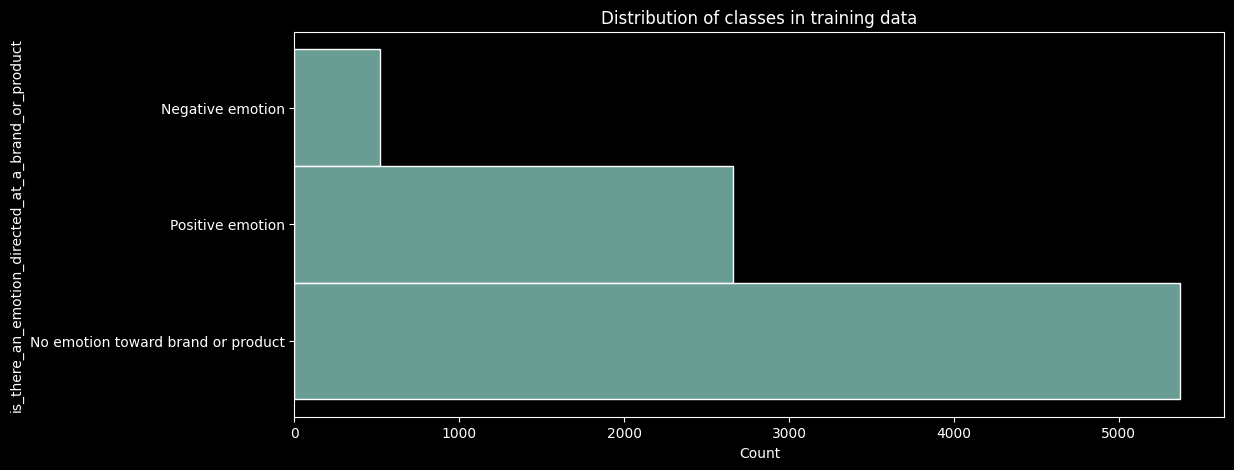

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 5))
plt.title('Distribution of classes in training data')

sns.histplot(y=df_train['is_there_an_emotion_directed_at_a_brand_or_product']);

In [5]:
df_test = pd.read_csv(TEST_PATH)
print(df_test.shape)
df_test.head()

(504, 1)


,Tweet
0,Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...
1,Again? RT @mention Line at the Apple store is ...
2,Boooo! RT @mention Flipboard is developing an ...
3,Thanks to @mention for publishing the news of ...
4,���@mention &quot;Apple has opened a pop-up st...


# TF-IDF and Logistic Regression from scratch

## TfidfVectorizer from scratch

In [6]:
def own_tokenizer(sample: str, min_token_length: int) -> List[str]:
    """
    Selects occurrences consisting of digits or letters of the English alphabet with a length of at least min_token_length.

    :param sample: source string;
    :param min_token_length: minimum token length;
    :return: list of tokens.
    """
    sample = sample.lower()
    tokens_of_sample = re.findall(r'[\w\d]+', sample)
    return [token for token in tokens_of_sample if len(token) >= min_token_length]

def nltk_tokenizer(tokenizer: nltk.tokenize, sample: str,
                   stop_words: set) -> list[str]:
    """
    NLTK tokenizer with stopwords.

    :param tokenizer: NLTK tokenizer;
    :param sample: source string;
    :param stop_words: stop words for language;
    :return: list of tokens.
    """
    tokens_of_sample = tokenizer.tokenize(sample.lower())
    return [token for token in tokens_of_sample if token not in stop_words]

In [7]:
tokenizer = TweetTokenizer()
en_stop_words = set(stopwords.words('english'))
corpus = df_train[df_train.columns[0]].tolist()
y = df_train[df_train.columns[1]].tolist()

own_tokenize = [own_tokenizer(sample=text, min_token_length=4) for text in corpus]
nltk_tokenize = [nltk_tokenizer(tokenizer,
                                sample=text,
                                stop_words=en_stop_words) for text in corpus]

' '.join(own_tokenize[0]), ' '.join(nltk_tokenize[0])

('wesley83 have iphone after tweeting rise_austin dead need upgrade plugin stations sxsw',
 '. @wesley83 3g iphone . 3 hrs tweeting #rise_austin , dead ! need upgrade . plugin stations #sxsw .')

In [8]:
X_own_train, X_own_val, y_train, y_val = train_test_split(own_tokenize, y,
                                                          test_size=0.2,
                                                          stratify=y,
                                                          shuffle=True,
                                                          random_state=RANDOM_STATE)

X_nltk_train, X_nltk_val, _, _ = train_test_split(nltk_tokenize, y,
                                                  test_size=0.2,
                                                  stratify=y,
                                                  shuffle=True,
                                                  random_state=RANDOM_STATE)

In [9]:
def get_vocabulary(tokenized_texts: list[list[str]], max_df: float,
                   min_df: int) -> Tuple[dict, np.array]:
    """
    Сreates a token vocabulary.

    :param tokenized_texts: source list;
    :param max_df: threshold document frequency;
    :param min_df: minimum token count;
    :return: vocabulary with frequencies.
    """
    token_cnt = collections.defaultdict(int)
    number_of_documents = len(tokenized_texts)

    for text in tokenized_texts:
        cur_unique_tokens = set(text)

        for token in cur_unique_tokens:
            token_cnt[token] += 1

    token_cnt = {token: cnt for token, cnt in token_cnt.items()
                 if (cnt / number_of_documents <= max_df) and (cnt >= min_df)}

    sorted_token_cnt = sorted(token_cnt.items(),
                              key=lambda x: x[1],
                              reverse=True)

    token2id = {token: i for i, (token, _) in enumerate(sorted_token_cnt)}
    doc_freq = np.array([cnt / number_of_documents for _, cnt in sorted_token_cnt], dtype=np.float32)

    return token2id, doc_freq

In [10]:
own_vocab, own_doc_freq = get_vocabulary(tokenized_texts=X_own_train,
                                         max_df=MAX_DF,
                                         min_df=MIN_DF)

nltk_vocab, nltk_doc_freq = get_vocabulary(tokenized_texts=X_nltk_train,
                                           max_df=MAX_DF,
                                           min_df=MIN_DF)
len(own_vocab), len(nltk_vocab)

(1721, 2001)

In [11]:
def vectorize_texts(tokenized_texts: list[list[int]], vocab: dict,
                    doc_freq: list[float]) -> scipy.sparse.dok_matrix:
    """
    Creates a sparse feature matrix.

    :param tokenized_texts: source list;
    :param vocab: vocabulary of source list;
    :param doc_freq: fraction of documents with a certain token to all documents;
    :return: sparse feature matrix.
    """
    matrix = scipy.sparse.dok_matrix((len(tokenized_texts), len(vocab)), dtype=np.float32)

    for i, text in enumerate(tokenized_texts):
        for token in text:
            if token in vocab.keys():
                matrix[i, vocab[token]] += 1

    matrix = matrix.tocsr()
    matrix = matrix.multiply(1 / matrix.sum(1))
    matrix = matrix.multiply(1 / doc_freq)

    matrix = matrix.tocsc()
    matrix -= matrix.min()
    matrix /= (matrix.max() + 1e-6)
    matrix = matrix.tocsr()

    return matrix

In [12]:
train_own_vectors = vectorize_texts(X_own_train, own_vocab, own_doc_freq)
val_own_vectors = vectorize_texts(X_own_val, own_vocab, own_doc_freq)

train_nltk_vectors = vectorize_texts(X_nltk_train, nltk_vocab, nltk_doc_freq)
val_nltk_vectors = vectorize_texts(X_nltk_val, nltk_vocab, nltk_doc_freq)

print(train_own_vectors.shape, val_own_vectors.shape, \
      train_nltk_vectors.shape, val_nltk_vectors.shape, sep='\n')

(6841, 1721)
(1711, 1721)
(6841, 2001)
(1711, 2001)


## Logistic Regression from scratch

In [13]:
label_name2id = {name: i for i, name in enumerate(set(y_train))}
label_name2id

{'No emotion toward brand or product': 0,
 'Negative emotion': 1,
 'Positive emotion': 2}

In [14]:
class CustomDataset(Dataset):
    def __init__(self, vectors: scipy.sparse.dok_matrix,
                 label_ids: list,
                 label_name2id: dict) -> NoReturn:
        self.vectors = vectors
        self.label_ids = label_ids
        self.label_name2id = label_name2id

    def __len__(self) -> int:
        return self.vectors.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor]:
        out_vectors = torch.from_numpy(self.vectors[idx].toarray()[0])
        out_label = torch.tensor(self.label_name2id[self.label_ids[idx]])
        return out_vectors, out_label

In [15]:
train_own_ds = CustomDataset(train_own_vectors, y_train, label_name2id)
val_own_ds = CustomDataset(val_own_vectors, y_val, label_name2id)

train_nltk_ds = CustomDataset(train_nltk_vectors, y_train, label_name2id)
val_nltk_ds = CustomDataset(val_nltk_vectors, y_val, label_name2id)

In [16]:
batch_size = 32

train_own_dl = DataLoader(dataset=train_own_ds, batch_size=batch_size,
                          shuffle=True, drop_last=True)
val_own_dl = DataLoader(dataset=val_own_ds, batch_size=batch_size,
                        shuffle=True, drop_last=True)

train_nltk_dl = DataLoader(dataset=train_nltk_ds, batch_size=batch_size,
                           shuffle=True, drop_last=True)
val_nltk_dl = DataLoader(dataset=val_nltk_ds, batch_size=batch_size,
                         shuffle=True, drop_last=True)

In [17]:
class LogisticRegression(nn.Module):
    def __init__(self, in_size: int,
                 out_size: int=3) -> NoReturn:
        super().__init__()
        self.fc1 = nn.Linear(in_size, out_size)
        self.act = nn.Sigmoid()

    def forward(self, x: torch.tensor) -> torch.tensor:
        out = self.fc1(x)
        out = self.act(out)
        return out

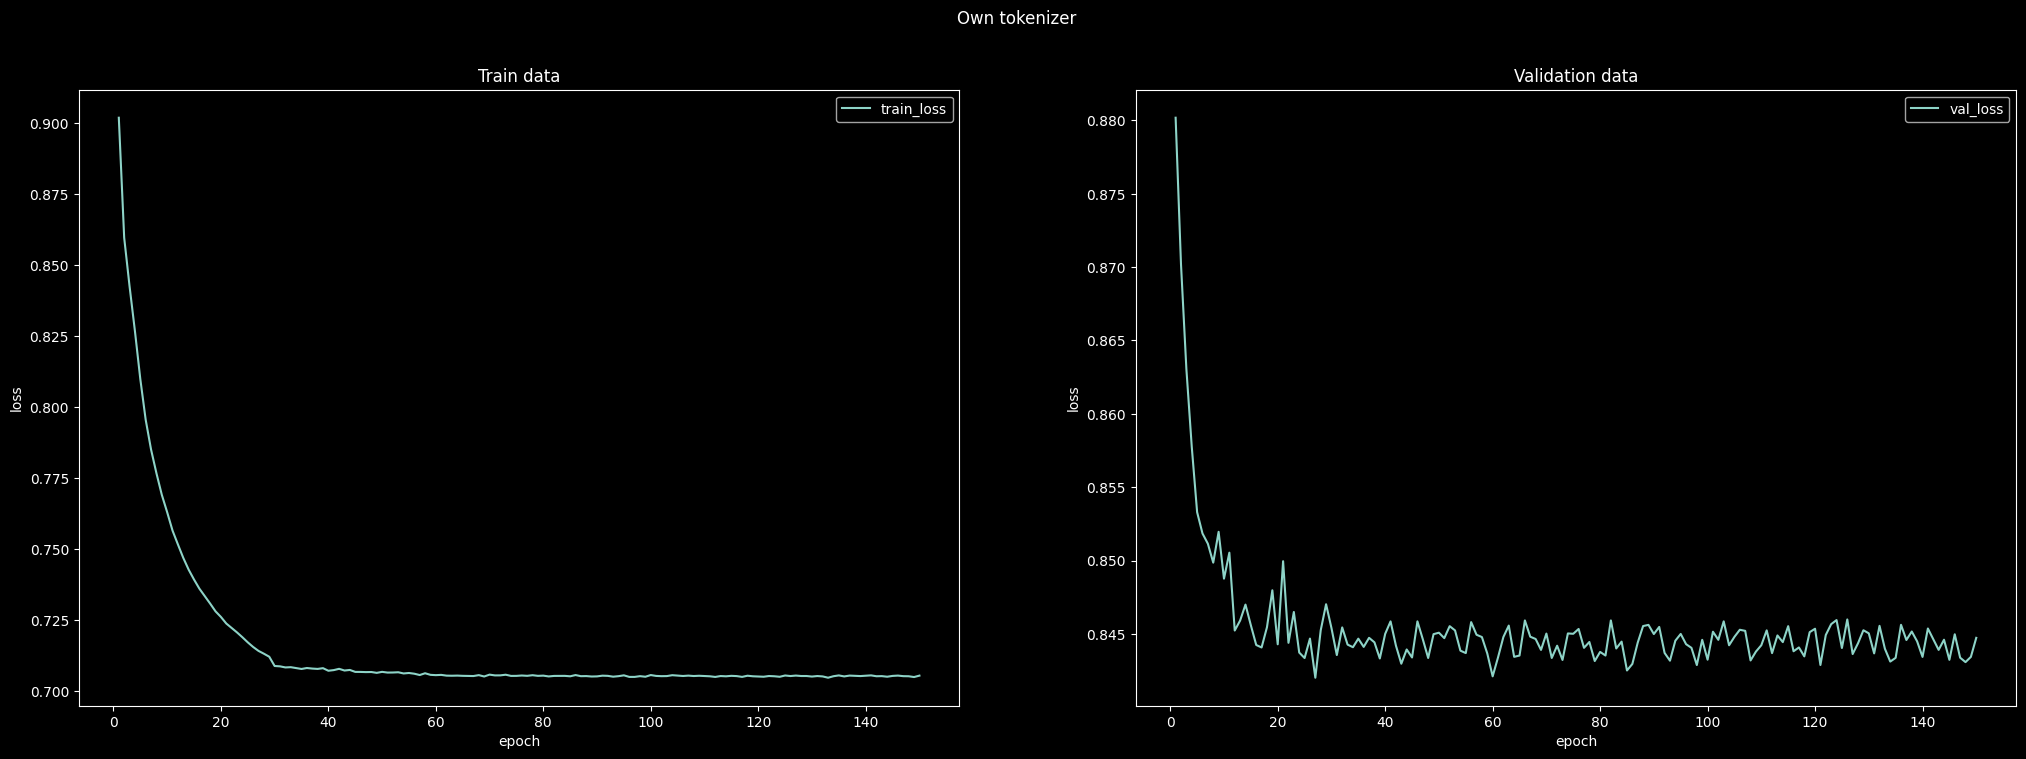

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LogisticRegression(len(own_vocab))
criterion = F.cross_entropy
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1,
                             betas=(0.9, 0.999), amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
epochs_num = 150
tokenizer_owner = 'Own tokenizer'

best_own_epoch, best_own_loss, best_own_model = train_model(model=model, device=device,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            scheduler=scheduler,
                                                            train_dl=train_own_dl,
                                                            val_dl=val_own_dl,
                                                            epochs_num=epochs_num,
                                                            suptitle_name=tokenizer_owner)

In [19]:
print(f'Own tokenizer:\n\
Best epoch with minimum validation loss = {best_own_epoch}\n\
Minimum validation loss = {np.around(best_own_loss, 4)}')

Own tokenizer:
Best epoch with minimum validation loss = 27
Minimum validation loss = 0.842


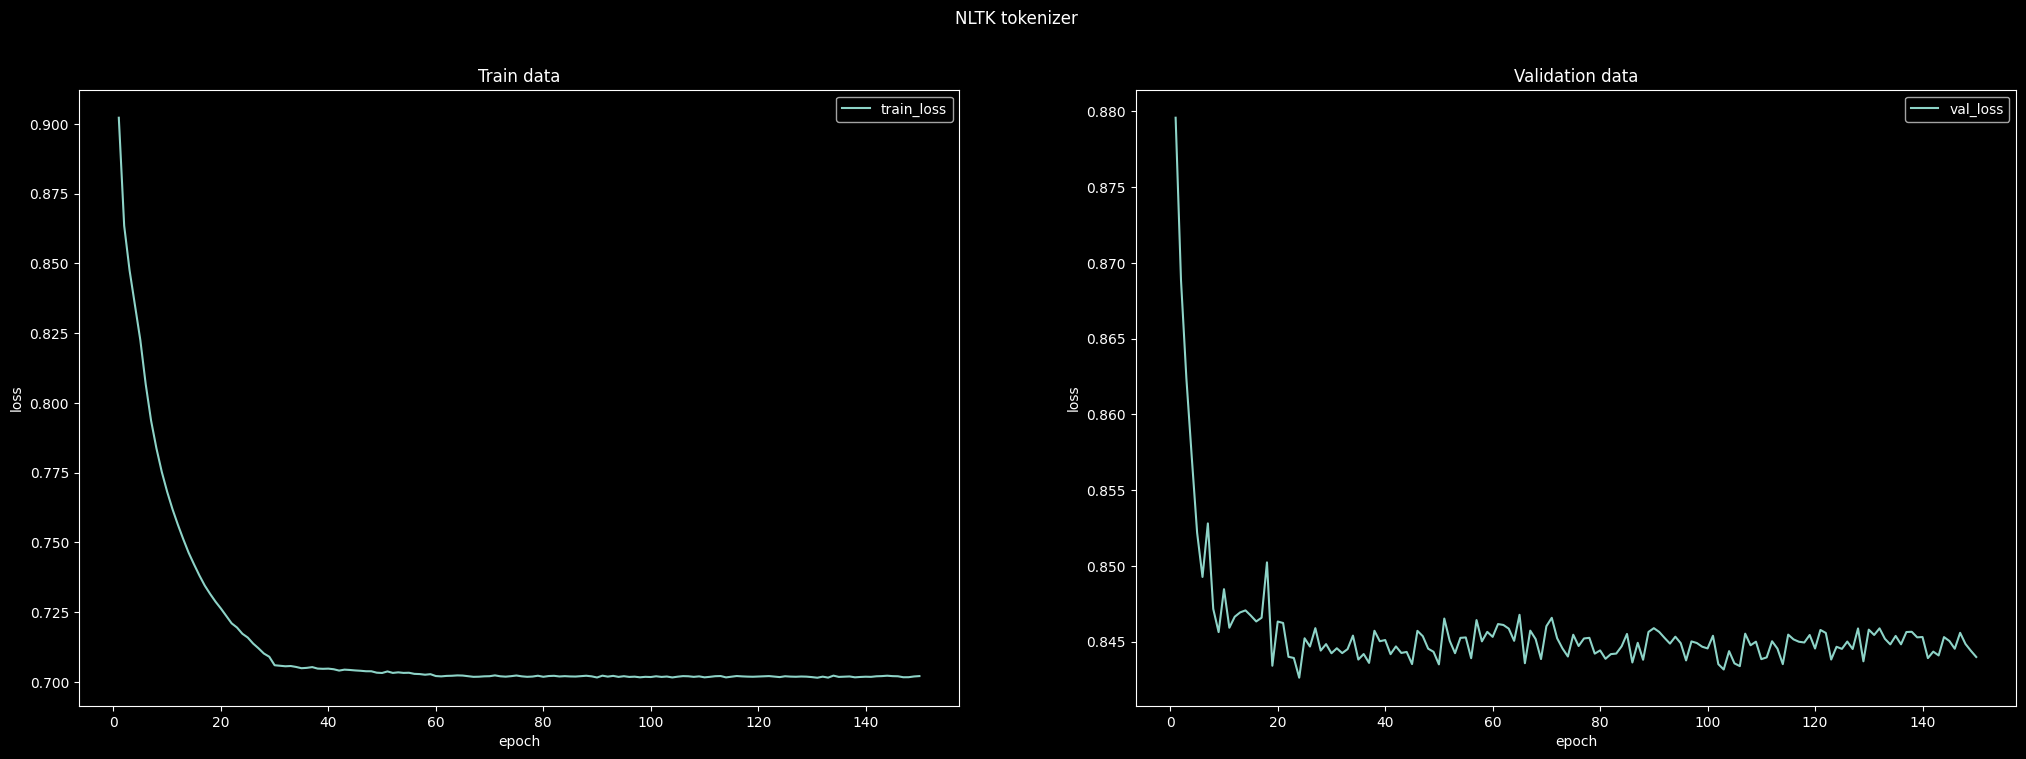

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LogisticRegression(len(nltk_vocab))
criterion = F.cross_entropy
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1,
                             betas=(0.9, 0.999), amsgrad=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
epochs_num = 150
tokenizer_owner = 'NLTK tokenizer'

best_nltk_epoch, best_nltk_loss, best_nltk_model = train_model(model=model, device=device,
                                                               criterion=criterion,
                                                               optimizer=optimizer,
                                                               scheduler=scheduler,
                                                               train_dl=train_nltk_dl,
                                                               val_dl=val_nltk_dl,
                                                               epochs_num=epochs_num,
                                                               suptitle_name=tokenizer_owner)

In [21]:
print(f'NLTK tokenizer:\n\
Best epoch with minimum validation loss = {best_nltk_epoch}\n\
Minimum validation loss = {np.around(best_nltk_loss, 4)}')

NLTK tokenizer:
Best epoch with minimum validation loss = 24
Minimum validation loss = 0.8426


Since our own model has the smallest validation error, we will continue working with it.

In [22]:
pred = predict_model(model=best_own_model, dl=val_own_dl, device=device)
pred.shape, pred[0]

  0%|          | 0/53 [00:00<?, ?it/s]

((1696,), 2)

In [23]:
label_id2name = {val: key for key, val in label_name2id.items()}
f = lambda x: label_id2name[x]

y_pred_from_scratch = np.array([f(label) for label in pred])
y_pred_from_scratch[0]

'Positive emotion'

In [24]:
len(y_val), y_pred_from_scratch.shape

(1711, (1696,))

In [25]:
print(classification_report(y_val[0:1696], y_pred_from_scratch))

                                    precision    recall  f1-score   support

                  Negative emotion       0.06      0.02      0.03       104
No emotion toward brand or product       0.63      0.77      0.69      1063
                  Positive emotion       0.32      0.22      0.26       529

                          accuracy                           0.55      1696
                         macro avg       0.34      0.34      0.33      1696
                      weighted avg       0.50      0.55      0.52      1696



# TF-IDF and Logistic Regression from scikit-learn

In [26]:
vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF)
X = vectorizer.fit_transform(df_train['tweet_text'])

X, len(y)

(<8552x2363 sparse matrix of type '<class 'numpy.float64'>'
 	with 118527 stored elements in Compressed Sparse Row format>,
 8552)

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
X_train, X_val, _, _ = train_test_split(X, y, test_size=0.2,
                                        stratify=y, shuffle=True,
                                        random_state=RANDOM_STATE)

clf = LogisticRegression(multi_class='auto', random_state=RANDOM_STATE,
                         n_jobs=-1)
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_val, y_val)

(0.7916971203040492, 0.7048509643483343)

In [30]:
y_pred_sklearn = clf.predict(X_val)
print(classification_report(y_val, y_pred_sklearn))

                                    precision    recall  f1-score   support

                  Negative emotion       0.78      0.07      0.12       104
No emotion toward brand or product       0.73      0.90      0.80      1075
                  Positive emotion       0.63      0.44      0.51       532

                          accuracy                           0.70      1711
                         macro avg       0.71      0.47      0.48      1711
                      weighted avg       0.70      0.70      0.67      1711



# Comparison of results

## Metrics

### TF-IDF and Logistic Regression from scratch

In [31]:
print(classification_report(y_val[0:1696], y_pred_from_scratch))

                                    precision    recall  f1-score   support

                  Negative emotion       0.06      0.02      0.03       104
No emotion toward brand or product       0.63      0.77      0.69      1063
                  Positive emotion       0.32      0.22      0.26       529

                          accuracy                           0.55      1696
                         macro avg       0.34      0.34      0.33      1696
                      weighted avg       0.50      0.55      0.52      1696



### Own TF-IDF and logistic regression from scikit-learn

In [32]:
mixed_clf = LogisticRegression(multi_class='auto', random_state=RANDOM_STATE,
                              n_jobs=-1)
mixed_clf.fit(train_own_vectors, y_train)

mixed_clf.score(train_own_vectors, y_train), \
mixed_clf.score(val_own_vectors, y_val)

(0.6376260780587634, 0.6300409117475161)

In [33]:
y_pred_mixed = mixed_clf.predict(val_own_vectors)
print(classification_report(y_val, y_pred_mixed))

                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00       104
No emotion toward brand or product       0.63      1.00      0.77      1075
                  Positive emotion       0.71      0.01      0.02       532

                          accuracy                           0.63      1711
                         macro avg       0.45      0.34      0.26      1711
                      weighted avg       0.62      0.63      0.49      1711



### TF-IDF and Logistic Regression from scikit-learn

In [34]:
print(classification_report(y_val, y_pred_sklearn))

                                    precision    recall  f1-score   support

                  Negative emotion       0.78      0.07      0.12       104
No emotion toward brand or product       0.73      0.90      0.80      1075
                  Positive emotion       0.63      0.44      0.51       532

                          accuracy                           0.70      1711
                         macro avg       0.71      0.47      0.48      1711
                      weighted avg       0.70      0.70      0.67      1711



## Summary

Both vectorizer and logistic regression from scikit-learn have many advantages, including sparse matrices, regularization, and variational vectorizers. Nevertheless, I believe that a similar result can be achieved from scratch, but there is rather little point in doing so.